In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
location="D:\s_chernov\AnacondaProjects\MLSSZ\Data\\"
df_train = pd.read_csv(location+"train.csv",sep=';',na_values="None")
df_test = pd.read_csv(location+"test.csv",sep=';',na_values="None")

In [3]:
del df_train['id']


In [4]:
df_train['age_year']=np.int16(df_train.age/365)
df_test['age_year']=np.int16(df_test.age/365)
df_train.loc[df_train.weight<20,'weight']=df_train.loc[df_train.weight<20,'weight']*10
df_test.loc[df_test.weight<20,'weight']=df_test.loc[df_test.weight<20,'weight']*10
df_train.loc[df_train.height<100,'height']=df_train.loc[df_train.height<100,'height']*10
df_test.loc[df_test.height<100,'height']=df_test.loc[df_test.height<100,'height']*10
#height and weight errors
correct=df_train.weight>df_train.height
correct_weight=df_train.loc[correct,'weight']
correct_height=df_train.loc[correct,'height']
df_train.loc[correct,'weight']=correct_height
df_train.loc[correct,'height']=correct_weight

correct=df_test.weight>df_test.height
correct_weight=df_test.loc[correct,'weight']
correct_height=df_test.loc[correct,'height']
df_test.loc[correct,'weight']=correct_height
df_test.loc[correct,'height']=correct_weight

#____ap_lo and ap_hi
df_train.loc[df_train.ap_lo<0,'ap_lo']=-df_train.loc[df_train.ap_lo<0,'ap_lo']
df_test.loc[df_test.ap_lo<0,'ap_lo']=-df_test.loc[df_test.ap_lo<0,'ap_lo']

df_train.loc[df_train.ap_lo>6000,'ap_lo']=df_train.loc[df_train.ap_lo>6000,'ap_lo']/100
df_train.loc[df_train.ap_lo>600,'ap_lo']=df_train.loc[df_train.ap_lo>600,'ap_lo']/10
df_test.loc[df_test.ap_lo>6000,'ap_lo']=df_test.loc[df_test.ap_lo>6000,'ap_lo']/100
df_test.loc[df_test.ap_lo>600,'ap_lo']=df_test.loc[df_test.ap_lo>600,'ap_lo']/10
df_train.loc[df_train.ap_lo<=10,'ap_lo']=df_train.loc[df_train.ap_lo<=10,'ap_lo']*10
df_test.loc[df_test.ap_lo<=10,'ap_lo']=df_test.loc[df_test.ap_lo<=10,'ap_lo']*10

df_train.loc[df_train.ap_hi<0,'ap_hi']=-df_train.loc[df_train.ap_hi<0,'ap_hi']
df_test.loc[df_test.ap_hi<0,'ap_hi']=-df_test.loc[df_test.ap_hi<0,'ap_hi']

df_train.loc[df_train.ap_hi>=10000,'ap_hi']=df_train.loc[df_train.ap_hi>=10000,'ap_hi']/100
df_test.loc[df_test.ap_hi>=10000,'ap_hi']=df_test.loc[df_test.ap_hi>=10000,'ap_hi']/100
df_train.loc[df_train.ap_hi>=300,'ap_hi']=df_train.loc[df_train.ap_hi>=300,'ap_hi']/10
df_test.loc[df_test.ap_hi>=300,'ap_hi']=df_test.loc[df_test.ap_hi>=300,'ap_hi']/10

df_train.loc[df_train.ap_hi<30,'ap_hi']=df_train.loc[df_train.ap_hi<30,'ap_hi']*10
df_test.loc[df_test.ap_hi<30,'ap_hi']=df_test.loc[df_test.ap_hi<30,'ap_hi']*10

correct=df_train.ap_hi<df_train.ap_lo
correct_hi=df_train.loc[correct,'ap_hi']
correct_lo=df_train.loc[correct,'ap_lo']
df_train.loc[correct,'ap_hi']=correct_lo
df_train.loc[correct,'ap_lo']=correct_hi

correct=df_test.ap_hi<df_test.ap_lo
correct_hi=df_test.loc[correct,'ap_hi']
correct_lo=df_test.loc[correct,'ap_lo']
df_test.loc[correct,'ap_hi']=correct_lo
df_test.loc[correct,'ap_lo']=correct_hi

In [5]:
#df_train['age_year']=np.int16(df_train.age/365)
#df_test['age_year']=np.int16(df_test.age/365)
#df_train['ap_div']=df_train.ap_lo/df_train.ap_hi
#df_test['ap_div']=df_test.ap_lo/df_train.ap_hi
#df_train['fat']=df_train.weight/(((df_train.height)/100)**2)
#df_test['fat']=df_test.weight/(((df_train.height)/100)**2)
#df_train['diff_weight']=50+0.75*(df_train.height-150) + (df_train.age_year-20)/4-df_train.weight
#df_test['diff_weight']=50+0.75*(df_test.height-150) + (df_test.age_year-20)/4-df_test.weight
#df_train['age_weight']=df_train.age/df_train.weight
#df_test['age_weight']=df_test.age/df_test.weight

In [6]:
df_test.alco=df_test.alco.fillna(0)
df_test.smoke=df_test.smoke.fillna(0)
df_test.active=df_test.active.fillna(1)
features=list(df_train.columns)
features.remove('cardio')


In [7]:
def xgb_factory(xgb_params):
    return( xgb.XGBClassifier(
             learning_rate=xgb_params['learning_rate'],
             n_estimators=xgb_params['n_estimators'],
             max_depth=xgb_params['max_depth'],
             min_child_weight=xgb_params['min_child_weight'],
             gamma=xgb_params['gamma'],
             subsample=xgb_params['subsample'],
             colsample_bytree=xgb_params['colsample_bytree'],
             objective=xgb_params['objective'],
             nthread=4,
             scale_pos_weight=1,
             seed=xgb_params['seed']))
       

In [8]:
cv = StratifiedKFold(df_train.cardio, n_folds=3, shuffle=True, random_state=123)

In [9]:
def makeCV(xgb_params,param_grid):
    hyper = xgb_factory(xgb_params)
    alg_xgb_grid = GridSearchCV(hyper, param_grid,cv=cv, scoring='neg_log_loss',refit=True, verbose=1, n_jobs=4)
    alg_xgb_grid.fit(df_train.loc[:,features],df_train.cardio)
    alg_xgb_best = alg_xgb_grid.best_estimator_
    print("Accuracy (xgboost auto): {} with params {}"
      .format(alg_xgb_grid.best_score_, alg_xgb_grid.best_params_))

    return alg_xgb_grid.best_params_


In [10]:
def tuneDepth(xgb_params):
    param_grid = {
             'max_depth':range(3,5,1),
             'min_child_weight':range(5,9,1)
    }
    best_params=makeCV(xgb_params,param_grid)
    xgb_params['max_depth']=best_params['max_depth']
    xgb_params['min_child_weight']=best_params['min_child_weight']
    return xgb_params

def tuneGamma(xgb_params):
    param_grid = {
         'gamma':[i/20.0 for i in range(0,6)]
        }
    best_params=makeCV(xgb_params,param_grid)

    xgb_params['gamma']=best_params['gamma']
    return xgb_params


def tuneSample(xgb_params):
   
    param_grid = {
         'subsample':[i/10.0 for i in range(6,10)],
         'colsample_bytree':[i/10.0 for i in range(6,10)]
        }

    best_params=makeCV(xgb_params,param_grid)


    xgb_params['subsample']=best_params['subsample']
    xgb_params['colsample_bytree']=best_params['colsample_bytree']
    return xgb_params

def tuneAlpha(xgb_params):
   
    param_grid = {
         'reg_alpha':[0.01, 0.013, 0.015, 0.017, 0.02, 0.023]
        }
    best_params=makeCV(xgb_params,param_grid)
    xgb_params['reg_alpha']=best_params['reg_alpha']
    return xgb_params

def tuneLearn(xgb_params):
    param_grid =  {"n_estimators": [900, 1000 , 1100, 1200, 1300],
        "learning_rate": [0.01, 0.015, 0.02]}

    best_params=makeCV(xgb_params,param_grid)

    xgb_params['n_estimators']=best_params['n_estimators']
    xgb_params['learning_rate']=best_params['learning_rate']
    return xgb_params

In [11]:
xgb_params={'colsample_bytree': 0.6,
 'eval_metric': 'logloss',
 'gamma': 0.1,
 'learning_rate': 0.02,
 'max_depth': 4,
 'min_child_weight': 8,
 'n_estimators': 900,
 'objective': 'binary:logistic',
 'reg_alpha': 0.017,
 'seed': 123,
 'silent': 1,
 'subsample': 0.9}

In [12]:
xgb_params=tuneDepth(xgb_params)
xgb_params=tuneGamma(xgb_params)
#xgb_params=tuneSample(xgb_params)
xgb_params=tuneAlpha(xgb_params)
xgb_params=tuneLearn(xgb_params)

print xgb_params

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:  4.7min finished


Accuracy (xgboost auto): -0.53873395723 with params {'max_depth': 4, 'min_child_weight': 8}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  3.8min finished


Accuracy (xgboost auto): -0.538730831088 with params {'gamma': 0.15}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  3.9min finished


Accuracy (xgboost auto): -0.538745089556 with params {'reg_alpha': 0.01}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  8.1min finished


Accuracy (xgboost auto): -0.538605874899 with params {'n_estimators': 1100, 'learning_rate': 0.01}
{'reg_alpha': 0.01, 'eval_metric': 'logloss', 'learning_rate': 0.01, 'n_estimators': 1100, 'seed': 123, 'colsample_bytree': 0.6, 'silent': 1, 'min_child_weight': 8, 'subsample': 0.9, 'objective': 'binary:logistic', 'max_depth': 4, 'gamma': 0.15}


In [18]:
xgb_params={'colsample_bytree': 0.6,
 'eval_metric': 'logloss',
 'gamma': 0.1,
 'learning_rate': 0.02,
 'max_depth': 4,
 'min_child_weight': 8,
 'n_estimators': 900,
 'objective': 'binary:logistic',
 'reg_alpha': 0.01,
 'seed': 123,
 'silent': 1,
 'subsample': 0.9}

xgb_params=tuneLearn(xgb_params)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  8.1min finished


Accuracy (xgboost auto): -0.538608121746 with params {'n_estimators': 1100, 'learning_rate': 0.01}


In [19]:
hyper = xgb_factory(xgb_params)
kfold = KFold(n_splits=10, random_state=7)
#results = cross_val_score(hyper, df_train.loc[:,features], df_train.cardio, cv=kfold,scoring='neg_log_loss',n_jobs=-1)
results = cross_val_score(hyper, df_train.loc[:,features], df_train.cardio, cv=kfold,scoring='neg_log_loss',n_jobs=-1)
print results.mean(),results.std()

fit=hyper.fit(df_train.loc[:,features],df_train.cardio,eval_metric='logloss')

#model = xgb.train(xgb_params,dtrain_all, num_boost_round=num_boost_round)
#pred = model.predict(dtest)
pred = fit.predict_proba(df_test.loc[:,features])[:,1]

-0.538178449821 0.00544668072141


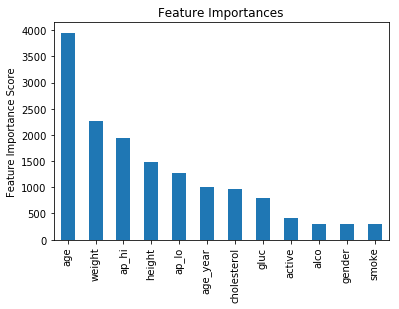

In [20]:
feat_imp = pd.Series(hyper.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [21]:
res=pd.DataFrame({'cardio':pred},columns=['id','cardio'])
res.cardio.to_csv(location+'submission.csv',index=False,header=False)